In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             3222 non-null   float64
 1   bath            3222 non-null   float64
 2   acre_lot        3222 non-null   float64
 3   zip_code        3222 non-null   float64
 4   house_size      3222 non-null   float64
 5   prev_sold_date  3222 non-null   object 
 6   price           3222 non-null   float64
dtypes: float64(6), object(1)
memory usage: 176.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             3222 non-null   float64
 1   bath            3222 non-null   float64
 2   acre_lot        3222 non-null   float64
 3   zip_code        3222 non-null   float64
 4   house_size      3222 non-null   float64
 5   price           3222 non-null   float64
 6   prev_sold_year  3222 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 176.3 KB


In [5]:
outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)

zip_code
8016.0    58
8081.0    55
8046.0    55
8210.0    51
8757.0    48
          ..
7081.0     1
8329.0     1
8327.0     1
8326.0     1
7853.0     1
Name: zip_code, Length: 421, dtype: int64

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([8016])]
#,8081,8046,8210

In [7]:
features = ["bed","bath","acre_lot","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

In [8]:
#"bed","bath","acre_lot","zip_code","house_size","prev_sold_year"
X = one_zipcode_df[features]
y = one_zipcode_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [9]:
results_dict = {"model":[],"mae score":[],"mse score":[],"r2 score":[]}

In [10]:
def print_more_stuff(title, y_param, predict_param):
    results_dict["model"].append(title)
    
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)    
    
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)

knn = KNeighborsRegressor()
knn_model = knn.fit(X_train,y_train)
knn_predict = knn_model.predict(X_test)
print_more_stuff("K Neighbors Regressor", y_test, knn_predict)

In [11]:
knn_gscv = GridSearchCV(KNeighborsRegressor(), {'n_neighbors': range(1, 10, 1)})
knn_gscv.fit(X,y)
print(f"Best parameters found: {knn_gscv.best_params_}")

Best parameters found: {'n_neighbors': 7}


In [12]:
knn_gscv_bp = KNeighborsRegressor(**knn_gscv.best_params_)
knn_gscv_bp.fit(X_train,y_train)
knn_predict = knn_gscv_bp.predict(X_test)
print_more_stuff("K Nearest Neighbors",y_test,knn_predict)

K Nearest Neighbors MSE = 7,501,174,143.816326
K Nearest Neighbors MAE = 64,279.095238
K Nearest Neighbors R2 = 0.392518


In [13]:
knn_sfs = SequentialFeatureSelector(KNeighborsRegressor(), n_features_to_select=num_features_to_select)
knn_sfs.fit(X, y)
knn_sfs_selected_features = knn_sfs.get_support()
print('The selected features are:', list(X.columns[knn_sfs_selected_features]))

The selected features are: ['bed', 'bath', 'acre_lot', 'prev_sold_year']


In [14]:
X_sfs = one_zipcode_df[list(X.columns[knn_sfs_selected_features])]
y_sfs = one_zipcode_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [15]:
knn_sfs = KNeighborsRegressor()
knn_sfs_model = knn_sfs.fit(X_sfs_train,y_sfs_train)
knn_sfs_predict = knn_sfs_model.predict(X_sfs_test)
print_more_stuff("Sequential Feature Selector", y_test, knn_sfs_predict)

Sequential Feature Selector MSE = 4,172,692,830.324444
Sequential Feature Selector MAE = 46,683.600000
Sequential Feature Selector R2 = 0.662075


In [16]:
knn_predict_df = pd.DataFrame(knn_predict).reset_index()
knn_predict_df.rename(columns={0: "prediction"},inplace=True)

knn_sfs_predict_df = pd.DataFrame(knn_sfs_predict).reset_index()
knn_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

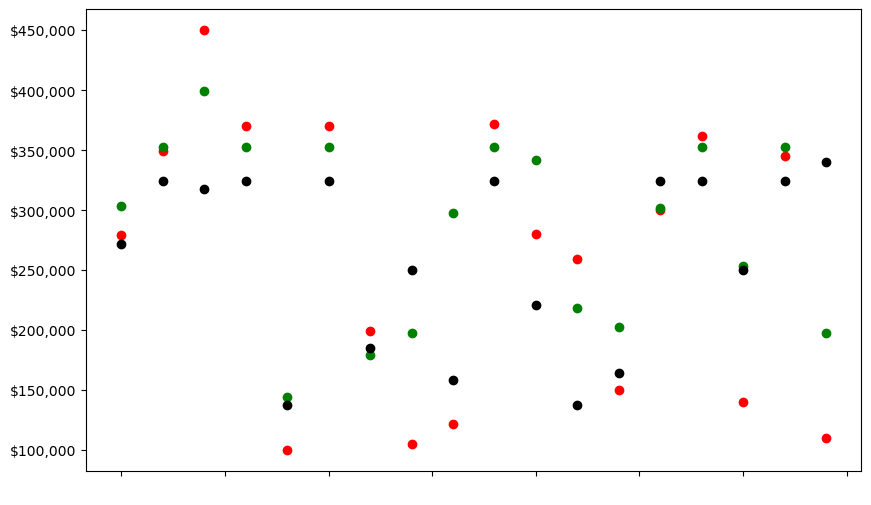

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(knn_sfs_predict_df.index,knn_sfs_predict_df["prediction"], color="green")
plt.scatter(knn_predict_df.index,knn_predict_df["prediction"], color="black")
plt.show()

In [18]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,mae score,mse score,r2 score
model,,,
K Nearest Neighbors,"64,279.095238","7,501,174,143.816326",0.392518
Sequential Feature Selector,"46,683.600000","4,172,692,830.324444",0.662075
